# Preliminaries: EDA; ARMA and ARIMA models

Notation:

- TS: time series

## Setup

In [1]:
import matplotlib.pyplot as plt
import sys
import pandas as pd
from pathlib import Path

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

### Download the data

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [3]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-03-21 11:26:42--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-03-21 11:26:43--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.008s  

2025-03-21 11:26:43 (12.8 MB/s) - ‘ridership.tgz’ saved [108512/108512]

mkdir: data: File exists
x ridership/
x ridership/CTA_-_Ridership_-_D

In [4]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded
a train. The `day_type` column contains `W` for Weekdays, `A` for Saturdays, and `U` for
Sundays or holidays.

# EDA

Notice the dramatic impact that the COVID pandemic had

Text(0.5, 0.98, 'Chicago Ridership Time Series')

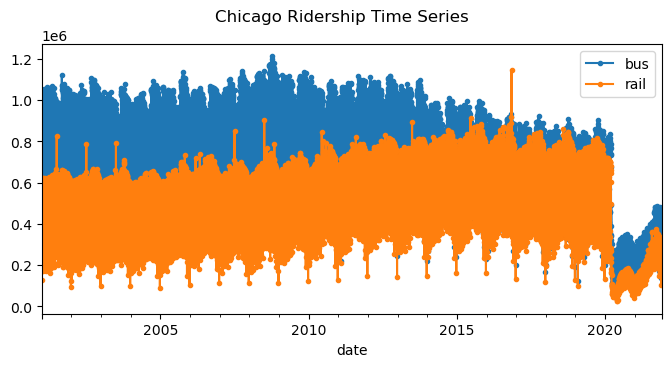

In [6]:
df.plot(marker=".", figsize=(8, 3.5))
plt.suptitle("Chicago Ridership Time Series")

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

Text(0.5, 0.98, 'Chicago Ridership Time Series')

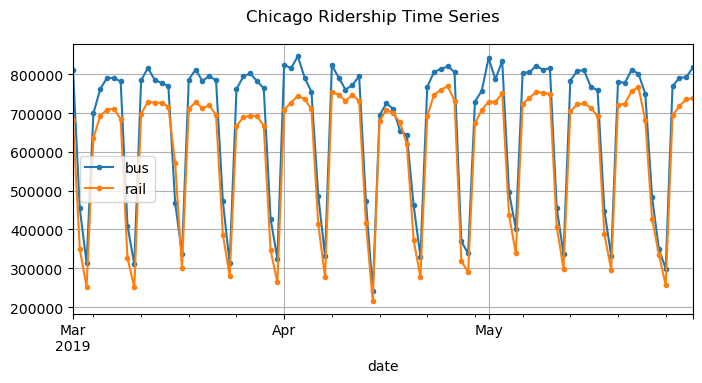

In [7]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.suptitle("Chicago Ridership Time Series")

## Naive forecasting

Let's begin with naive forecasts, overlaying the two time series (for bus and rail) as
well as the same time series lagged by one week (i.e., shifted toward the right) using
dotted lines. 

We’ll also plot the difference `diff_7` between the two (i.e., the value at time t
minus the value at time t – 7) (*differencing*).

In [8]:
t0,t1="2019-03","2019-05"

Text(0.5, 1.0, '7-Day Difference')

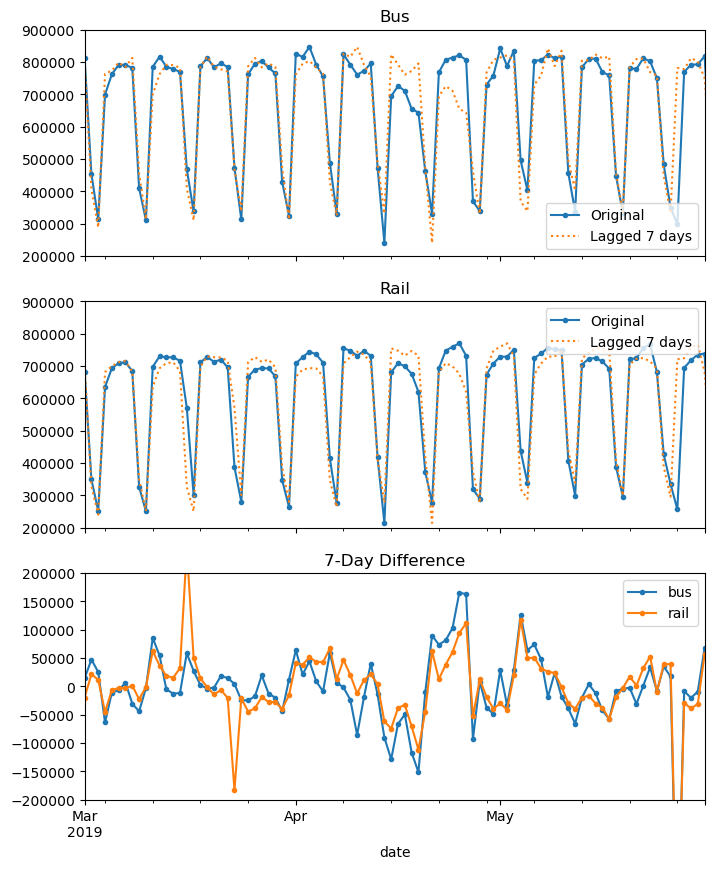

In [9]:
diff_7 = df[["bus", "rail"]].diff(7)[t0:t1]

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 10))
#df.plot(ax=axs[0], legend=False, marker=".")  # original time series
#df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged

df['bus'].plot(ax=axs[0], marker=".", label='Original')  
df['bus'].shift(7).plot(ax=axs[0], linestyle=":", label='Lagged 7 days')  
axs[0].set_ylim([2e5, 9e5]) 
axs[0].legend(loc="lower right")

df['rail'].plot(ax=axs[1], marker=".", label='Original')  
df['rail'].shift(7).plot(ax=axs[1], linestyle=":", label='Lagged 7 days')  
axs[1].set_ylim([2e5, 9e5]) 
axs[1].legend(loc="upper right")

diff_7.plot(ax=axs[2], marker=".")  # 7-day difference time series
axs[2].set_ylim([-2e5, 2e5]) 

axs[0].set_title("Bus")
axs[1].set_title("Rail")
axs[2].set_title("7-Day Difference")

The lagged time series tracks closely the actual time series. Lots of autocorrelation—when a time series is correlated with a lagged version of itself. Most of the differences are fairly small, except at the end of May (Memorial Day weekend as checked below). 

In [10]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE):

In [11]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [12]:
targets = df[["bus", "rail"]][t0:t1]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

## Seasonality and trends

Now let's look at the yearly seasonality and the long-term trends:

In [13]:
period = slice("2001", "2019")

# resample based on the monthly mean
# had to include a clause to restrict the operation only to numeric columns
df_monthly = df.select_dtypes(include='number').resample('ME').mean()

# resample using yearly means
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

Text(0.5, 1.0, 'Monthly and yearly aggregates')

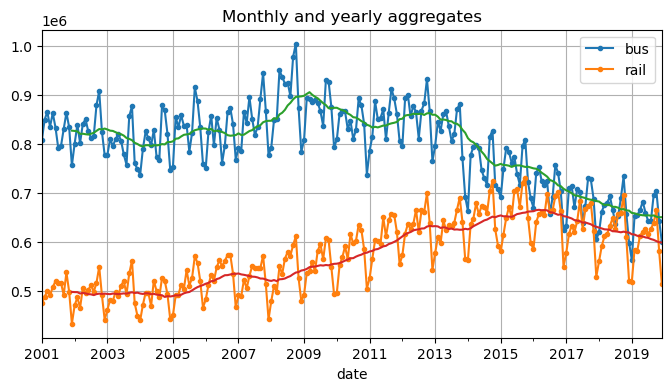

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.title('Monthly and yearly aggregates')

Text(0.5, 1.0, '12-months difference')

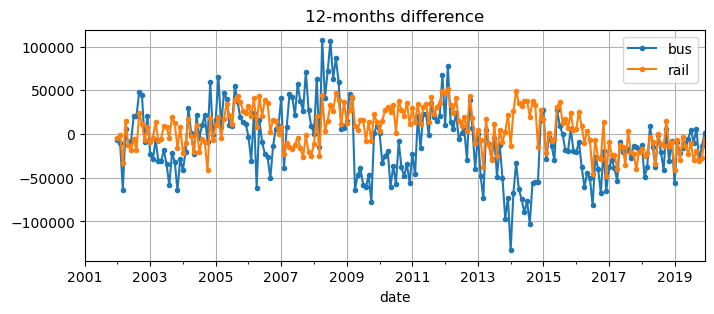

In [63]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.title('12-months difference')

## Autocorrelation function

**ACF.** `plot_acf` generates a visual representation of how the TS is correlated with itself over various lags, which is useful for identifying patterns, seasonality, or determining stationarity in the data.

`plot_acf` calculates the autocorrelation funcion (ACF) of the time series for each lag up to the specified maximum lag. On the plot, the x-axis represents the lag (i.e., how far back in time you’re comparing the series to itself). The y-axis represents the autocorrelation coefficients, which measure the linear relationship between the time series at different lags. It also plots horizontal lines (often representing confidence intervals) to help determine which lag correlations are statistically significant.

**PACF.** `plot_pacf` computes and plots the **partial autocorrelation function (PACF)**. The PACF measures the correlation between the TS and its lagged version *after removing the influence of the intermediate lags*. For example, while the ACF for lag 2 includes both the direct influence of data two steps back and the indirect influence mediated through lag 1, the PACF for lag 2 isolates the direct relationship between an observation and its observation two time steps earlier (after accounting for lag 1).

**Usefulness.** The ACF plot is extremely useful as a first TS diagnostic for:

- Identifying patterns and seasonality in your data
- Helping determine parameters for ARIMA models (particularly the MA component)
- Checking if a series is stationary (ACF of stationary series typically decays quickly)

The PACF is primarily used for identifying the order of AR terms in ARIMA models.

**Usage in Model Identification:** In practice, we look at both plots together:

- Sharp cutoff in PACF with gradually decaying ACF? AR process
- Sharp cutoff in ACF with gradually decaying PACF? MA process
- Both showing significant spikes at seasonal lags? Seasonal component present. PACF particularly helpful in determining which lagged values actually add predictive power versus those that are just artifacts of correlation structure.



How to plot the Autocorrelation Function (ACF) and the partial Autocorrelation Function (PACF)

Text(0.5, 0, 'Lag (days)')

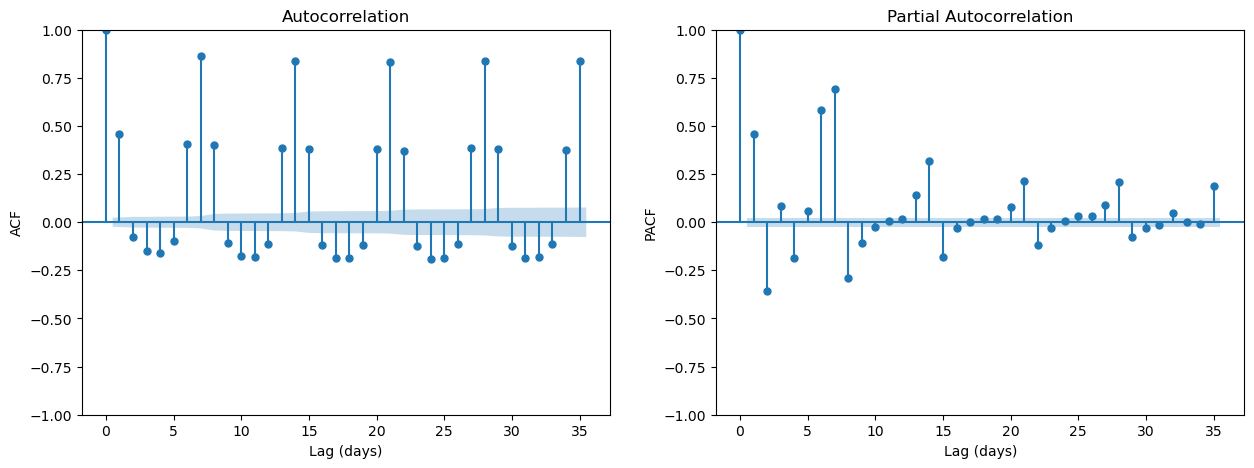

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].set_xlabel('Lag (days)')
axs[0].set_ylabel('ACF')

plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].set_ylabel('PACF')
axs[1].set_xlabel('Lag (days)')

Now let's inspect if there is a yearly seasonality.

In [79]:
period_yrs = slice("2001", "2019")

Text(0.5, 0, 'Lag (months)')

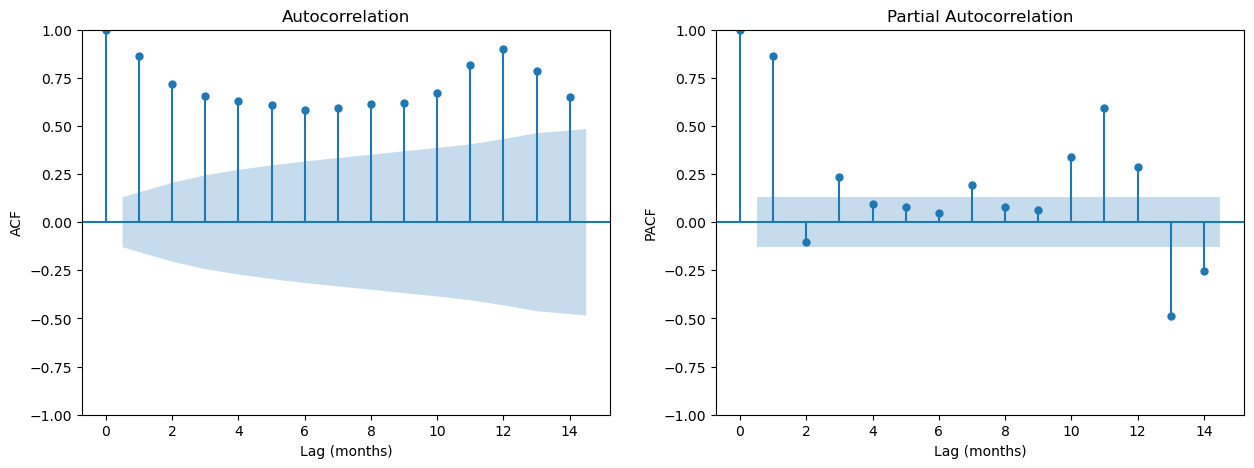

In [82]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df_monthly[period_yrs]["rail"], ax=axs[0], lags=14)
axs[0].set_xlabel('Lag (months)')
axs[0].set_ylabel('ACF')

plot_pacf(df_monthly[period_yrs]["rail"], ax=axs[1], lags=14, method="ywm")
axs[1].set_ylabel('PACF')
axs[1].set_xlabel('Lag (months)')

# Forecasting with (S)AR(I)MA

If running on Colab or Kaggle, install the statsmodels library:

In [16]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

## ARMA

ARMA models are simpler and do not handle explicit seasonality like SARIMA does. **ARMA** models only consider non-seasonal autoregressive (AR) and moving average (MA) components. These models assume the series is stationary.

To fit an ARMA model in `statsmodels`, we use the `ARIMA` class and omit the `seasonal_order` argument. It has two hyperparameters: $p$ and $q$—how far back in the autoregressive and moving average terms. For example, `order=(1, 0, 1)` means that `p = 1, d = 0, q = 1` (no differencing, with moving average term).


Specifies the time window

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

In [18]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")

### Determining the hyperparameters

The partial autocorrelation plot (PACF) is a valuable tool for determining the autoregressive (AR) component of your ARIMA model—that is, the \(p\) in the order \((p, d, q)\). In an ideal AR(\(p\)) process, the PACF will show significant values (i.e., points outside the confidence interval) up to lag \(p\) and then drop off to near zero for higher lags. For example:
   
   - If the PACF cuts off sharply after lag 2 (meaning lags 1 and 2 are significant, and lag 3 and beyond fall inside the confidence intervals), that suggests \(p=2\).
   - If the decay is more gradual rather than a sharp cut, you might need to experiment with a slightly higher order to capture the dynamics, but always balance with the risk of overfitting.
Based on the ACF and PACF, I choose `p = 7` and `q = 7`.

In [94]:
p,d,q=7,0,1

### One step ahead

Predict one point ahead.

In [95]:
model = ARIMA(rail_series, order=(p, d, q))

We fit the model and make a forecast for tomorrow.

In [96]:
model = model.fit()
y_pred = model.forecast()

Forecast

In [97]:
y_pred

2019-06-01    508924.220094
Freq: D, dtype: float64

Ground truth

In [98]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [99]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

MAE

In [100]:
abs(y_pred.iloc[0]-df["rail"].loc["2019-06-01"])

129880.22009449435

### Full TS

#### Recursive

Train once, recursively forecast.

In [101]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

In [102]:
# trains model on time_period
model_ARMA_r = ARIMA(rail_series[origin:"2019-02-28"], order=(p, d, q))
model_ARMA_r = model_ARMA_r.fit()

# prediction with confidence band
nt=len(time_period)
y_preds_ARMA_r = model_ARMA_r.forecast(steps=nt)
y_preds_ARMA_r = pd.Series(y_preds_ARMA_r, index=time_period)
# We compute MAE over the March-May interval.
mae_ARMA_r = (y_preds_ARMA_r - rail_series[time_period]).abs().mean()

In [103]:
print("MAE = "+str(round(mae_ARMA_r)))

MAE = 159667


Displays the ARMA forecasts

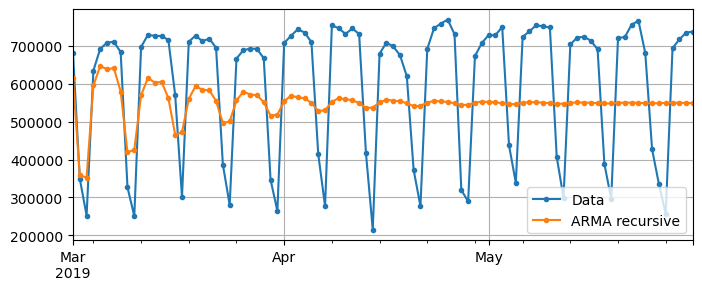

In [104]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_preds_ARMA_r, marker=".", label="ARMA recursive")
plt.legend(fontsize=10, loc='lower right')

This is how you get confidence intervals. `pred_ts` and `pred_ci` are full pandas TS objects.

In [109]:
pred=model_ARMA_r.get_forecast(steps=10)
pred_ts=pred.predicted_mean
pred_ci = pred.conf_int()  # default 95% confidence intervals

**Conclusion:** Recursive predictions are only good at predicting the mean. Wow.

#### Retraining

Training loop

In [105]:
%%time
y_preds_ARMA = []

# Shifting the date range by -1: each date is moved one day earlier.
for today in tqdm(time_period.shift(-1)):
    # Define the ARMA model
    model_ARMA = ARIMA(rail_series[origin:today], order=(p, d, q))
    # note that we retrain the model every day on data up to "today"
    model_ARMA = model_ARMA.fit()
    # predict next day
    y_pred = model_ARMA.forecast().iloc[0]
    y_preds_ARMA.append(y_pred)

y_preds_ARMA = pd.Series(y_preds_ARMA, index=time_period)
mae_ARMA = (y_preds_ARMA - rail_series[time_period]).abs().mean()  # returns 32,040.7

100%|███████████████████████████████████| 92/92 [00:14<00:00,  6.21it/s]

CPU times: user 1min 15s, sys: 27 s, total: 1min 42s
Wall time: 14.8 s


In [106]:
print("MAE = "+str(round(mae_ARMA)))

MAE = 60061


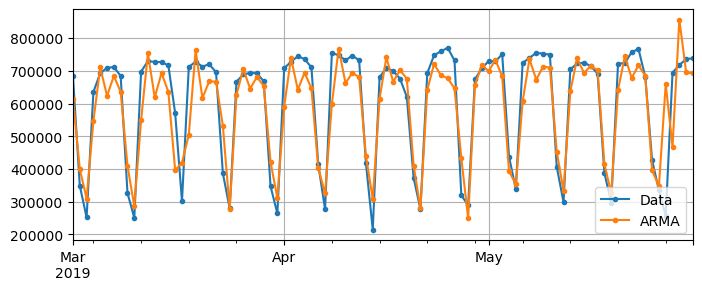

In [107]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_preds_ARMA, marker=".", label="ARMA")
plt.legend(fontsize=10, loc='lower right')

In [108]:
print(model_ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   rail   No. Observations:                  150
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -1946.950
Date:                Fri, 21 Mar 2025   AIC                           3913.900
Time:                        14:43:22   BIC                           3944.006
Sample:                    01-01-2019   HQIC                          3926.131
                         - 05-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.82e+05   2.38e+04     24.489      0.000    5.35e+05    6.29e+05
ar.L1         -0.0095      0.102     -0.093      0.926      -0.209       0.190
ar.L2         -0.0869      0.090     -0.961      0.3

## ARIMA

The process is very similar to SARIMA but without explicitly modeling seasonality (i.e., no `seasonal_order` parameter). An **ARIMA** model assumes there is no seasonality, and it focuses on the non-seasonal components: **AR (autoregression)**, **I (differencing to remove trends)**, and **MA (moving average)**.

For the parameters `order=(p, d, q)`, `d` is non-zero.

In [111]:
d=1

In [113]:
%%time
y_preds_ARIMA = []
for today in tqdm(time_period.shift(-1)):
    model_ARIMA = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(p, d, q))
    model_ARIMA = model_ARIMA.fit()  # note that we retrain the model every day!
    y_pred = model_ARIMA.forecast().iloc[0]
    y_preds_ARIMA.append(y_pred)

y_preds_ARIMA = pd.Series(y_preds_ARIMA, index=time_period)
mae_ARIMA = (y_preds_ARIMA - rail_series[time_period]).abs().mean()  

 14%|████▉                              | 13/92 [00:02<00:16,  4.84it/s]/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 15%|█████▎                             | 14/92 [00:02<00:15,  5.13it/s]/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 16%|█████▋                             | 15/92 [00:02<00:14,  5.25it/s]/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 20%|██████▊                

CPU times: user 1min 48s, sys: 47.2 s, total: 2min 35s
Wall time: 23 s


In [114]:
print("MAE = "+str(round(mae_ARIMA)))

MAE = 62281


Displays the ARIMA forecasts

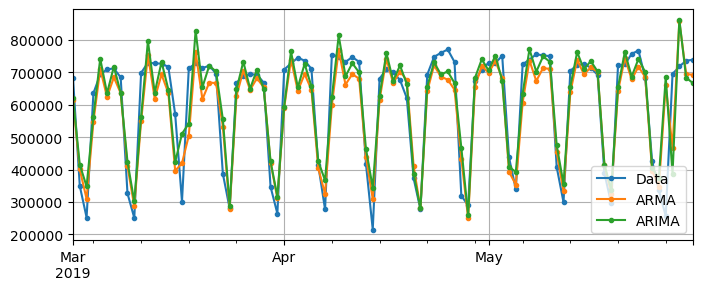

In [115]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_preds_ARMA, marker=".", label="ARMA")
ax.plot(y_preds_ARIMA, marker=".", label="ARIMA")
plt.legend(fontsize=10, loc='lower right')

## SARIMA

**BASICS**

Seasonal ARIMA (SARIMA) model: models the time series in the same way as ARIMA, but it additionally models
a seasonal component for a given frequency (e.g., weekly), using the exact same
ARIMA approach. 

It has a total of seven hyperparameters: 

- $p$ and $q$ from ARMA: how far back in the autoregressive and moving average terms
- $d$ from ARIMA: how many rounds of differencing
- $P$, $D$, and $Q$ seasonal pattern
- $s$: period

Below, 

- `order=(1, 0, 0)` means that `p = 1, d = 0, q = 0` (no differencing, no moving average term)
- `seasonal_order=(0, 1, 1, 7)` means that `P = 0, D = 1, Q = 1`, and `s = 7` (period = 7 days)

In [116]:
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))

To check the accuracy of the model, we run the same code in a loop to make forecasts for every day in March,
April, and May, and compute the MAE over that period

In [121]:
y_preds = []
for today in tqdm(time_period.shift(-1)):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

100%|███████████████████████████████████| 92/92 [00:03<00:00, 24.34it/s]


In [122]:
mae

32040.720093807828

Displays the SARIMA forecasts

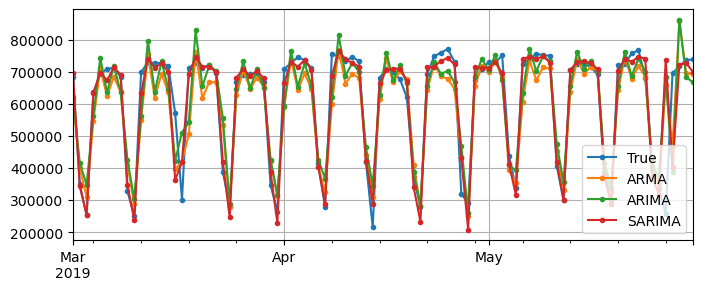

In [123]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds_ARMA, marker=".", label="ARMA")
ax.plot(y_preds_ARIMA, marker=".", label="ARIMA")
ax.plot(y_preds, marker=".", label="SARIMA")
plt.legend(fontsize=10, loc='lower right')
plt.show()

## Comparing the MAE

| Model  | MAE$\times 1000$    |
|--------|----------|
| ARMA   | 60  |
| ARIMA  | 62   |
| SARIMA | 32 |

Also notice how in the AR(I)MA models we reproduce the seasonal pattern using a AR(7) process, increasing the number of parameters. The SARIMA does a better job with seasonality.

An **AR(p) process** (autoregressive process of order *p*) is a time series model where the current value of the series is expressed as a linear combination of its previous *p* values and a random error term. The general form of the AR(p) model is:
$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t$$
where:

- **\(y_t\)** is the value of the time series at time *t*.
- **\(c\)** is a constant (or intercept) term.
- **\(\phi_1, \phi_2, \dots, \phi_p\)** are the coefficients that measure the influence of the previous \(y\)-values on the current value.
- **\(\varepsilon_t\)** is the error term (often assumed to be white noise with mean zero and constant variance).